In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec

## Import data

In [2]:
file_confirmed='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
file_deaths='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
file_recovered='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

df_confirmed=pd.read_csv(file_confirmed)
df_deaths=pd.read_csv(file_deaths)
df_recovered=pd.read_csv(file_recovered)

In [3]:
df_recovered.iloc[0,4:]

1/22/20      0
1/23/20      0
1/24/20      0
1/25/20      0
1/26/20      0
          ... 
4/16/20     54
4/17/20     99
4/18/20    112
4/19/20    131
4/20/20    135
Name: 0, Length: 90, dtype: object

### Data manipulation and representation (World)

In [4]:
deaths_world=df_deaths.iloc[:,-1].sum()
recovered_world=df_recovered.iloc[:,-1].sum()
total_world=df_confirmed.iloc[:,-1].sum()

max_death_rate=round(deaths_world/(deaths_world+recovered_world)*100,1)
min_death_rate=round(deaths_world/total_world*100,1)

print('Total contaminated:',total_world)
print('Total deaths:',deaths_world)
print('Total recovered:',recovered_world)

print('Based on the WHO data, the death rate is between',min_death_rate,'% and',max_death_rate,'% of the confirmed case')

Total contaminated: 2472258
Total deaths: 169985
Total recovered: 645738
Based on the WHO data, the death rate is between 6.9 % and 20.8 % of the confirmed case


5.16988997199193
2.9510060259652424


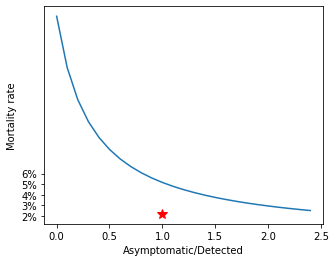

In [5]:
def mortality_rate(f_asympt):
    recovered_tot=recovered_world+f_asympt*total_world
    return deaths_world/(deaths_world+recovered_tot)

print(mortality_rate(1)*100)
print(mortality_rate(2)*100)

f_asympt_grid=np.arange(0,2.5,0.1)

plt.figure(figsize=(5,4))
plt.plot(f_asympt_grid,mortality_rate(f_asympt_grid)*100)
plt.xlabel('Asymptomatic/Detected')
plt.ylabel('Mortality rate')
plt.yticks([1,2,3,4,5,6],['1%','2%','3%','4%','5%','6%'])
plt.plot(1,2.2,marker='*',color='red',markersize=11)
plt.savefig('mortality_rate_plot.png',dpi=300)
plt.show()

In [6]:
def func_plot(df):
    y_world=[]
    n_cols=df.shape[1]
    #print(n_cols)
    for i in range(n_cols-4):
        y_world.append(df.iloc[:,i+4].sum())
    
    x_world2=df.columns[4:]
    x_world=pd.to_datetime(x_world2,infer_datetime_format=False)
    
    return (x_world,y_world)

peppe=func_plot(df_confirmed)

/Users/andreapalladino/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


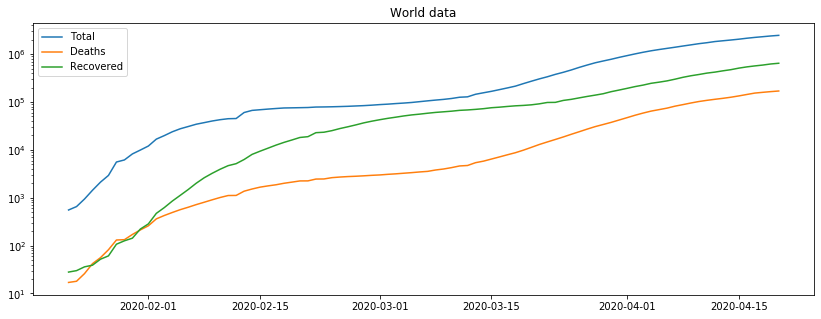

In [7]:
plt.figure(figsize=(14,5))
plt.plot(func_plot(df_confirmed)[0],func_plot(df_confirmed)[1],label='Total')
plt.plot(func_plot(df_deaths)[0],func_plot(df_deaths)[1],label='Deaths')
plt.plot(func_plot(df_recovered)[0],func_plot(df_recovered)[1],label='Recovered')
plt.legend()
plt.yscale('log')
plt.title('World data')
plt.savefig('world_plot.png',dpi=300)
plt.show()

### Data manipulation and representation (single country)

In [8]:
######## INPUT PARAMETERS ########
country='Germany'
t0=pd.to_datetime('2020-02-21')
#################################

mask_ita=df_confirmed['Country/Region']==country   # you can change the country here
mask_ita_rec=df_recovered['Country/Region']==country

df_confirmed_ITA=df_confirmed.loc[mask_ita,:]
df_deaths_ITA=df_deaths.loc[mask_ita,:]
df_recovered_ITA=df_recovered.loc[mask_ita_rec,:]

deaths_world_ITA=df_deaths_ITA.iloc[:,-1].sum()
recovered_world_ITA=df_recovered_ITA.iloc[:,-1].sum()
total_world_ITA=df_confirmed_ITA.iloc[:,-1].sum()

max_death_rate_ITA=round(deaths_world_ITA/(deaths_world_ITA+recovered_world_ITA)*100,1)
min_death_rate_ITA=round(deaths_world_ITA/total_world_ITA*100,1)

print('Total contaminated:',country,total_world_ITA)
print('Total deaths',country,deaths_world_ITA)
print('Total recovered ',country,recovered_world_ITA)

print('Based on the WHO data, the death rate in',country,'is between',min_death_rate_ITA,'% and',max_death_rate_ITA,'% of the total confirmed case')

Total contaminated: Germany 147065
Total deaths Germany 4862
Total recovered  Germany 91500
Based on the WHO data, the death rate in Germany is between 3.3 % and 5.0 % of the total confirmed case


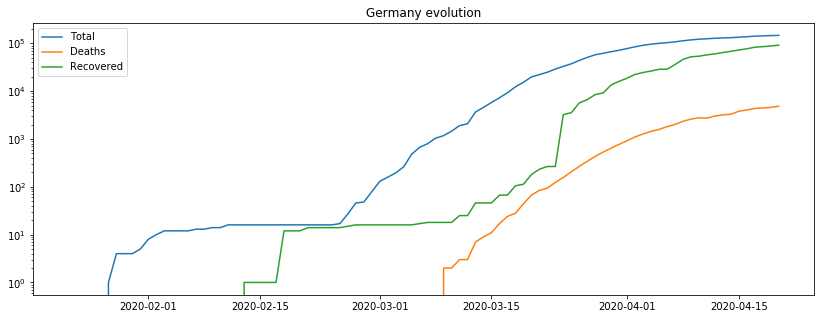

In [9]:
plt.figure(figsize=(14,5))
plt.plot(func_plot(df_confirmed_ITA)[0],func_plot(df_confirmed_ITA)[1],label='Total')
plt.plot(func_plot(df_deaths_ITA)[0],func_plot(df_deaths_ITA)[1],label='Deaths')
plt.plot(func_plot(df_recovered_ITA)[0],func_plot(df_recovered_ITA)[1],label='Recovered')
plt.legend()
plt.yscale('log')
plt.title(country+' evolution')
plt.savefig('country_plot.png',dpi=300)
plt.show()

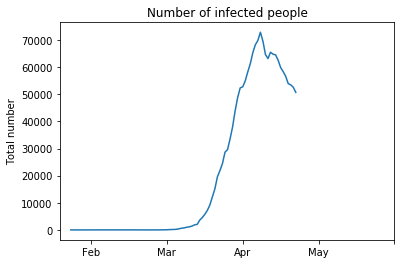

In [10]:
ytot=np.array(func_plot(df_confirmed_ITA)[1])
ydeaths=np.array(func_plot(df_deaths_ITA)[1])
yrec=np.array(func_plot(df_recovered_ITA)[1])

plt.plot(ytot-ydeaths-yrec)
#plt.yscale('log')
plt.xticks(np.arange(8,130,30),['Feb','Mar','Apr','May'])
plt.ylabel('Total number')
plt.title('Number of infected people')
plt.savefig('activegermany.png',dpi=300)
plt.show()

### Generalization to other countries

In [11]:
def whichcountry(name):
        
    ######## INPUT PARAMETERS ########
    country=name
    t0=pd.to_datetime('2020-02-21')
    #################################

    mask_ita=df_confirmed['Country/Region']==country   # you can change the country here
    mask_ita_rec=df_recovered['Country/Region']==country

    df_confirmed_ITA=df_confirmed.loc[mask_ita,:]
    df_deaths_ITA=df_deaths.loc[mask_ita,:]
    df_recovered_ITA=df_recovered.loc[mask_ita_rec,:]

    ytot=np.array(func_plot(df_confirmed_ITA)[1])
    ydeaths=np.array(func_plot(df_deaths_ITA)[1])
    yrec=np.array(func_plot(df_recovered_ITA)[1])

    return ytot-ydeaths-yrec, ytot[-1], yrec[-1],ydeaths[-1]


#definition of time
df_time=pd.to_datetime(np.arange(len(ytot)),unit='D',origin=pd.Timestamp('2020-01-22'))

In [12]:
# list of top countries , with the higher number of cases

df_nofcases=pd.DataFrame(np.array(df_confirmed.iloc[:,1]))
df_nofcases.columns=['Country']
df_nofcases['Confirmed']=df_confirmed.iloc[:,-1]

df_nofcases
np.array(df_nofcases.sort_values(by='Confirmed',ascending=False).head(6)['Country'])

array(['US', 'Spain', 'Italy', 'France', 'Germany', 'United Kingdom'],
      dtype=object)

In [13]:
# choose the country here
countries_list=['US', 'Spain', 'Italy', 'Germany', 'France', 'United Kingdom']

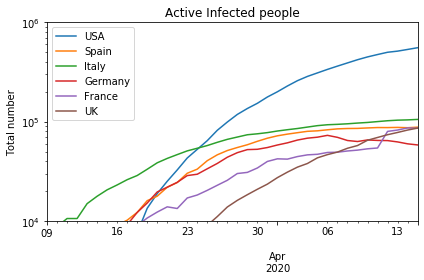

In [14]:
df_active=pd.DataFrame(whichcountry('US')[0])
df_active.columns=['US']
df_active.index=df_time

for i in range(1,len(countries_list)):
    df_active[countries_list[i]]=whichcountry(countries_list[i])[0]

df_active.columns=['USA','Spain','Italy','Germany','France','UK']
    
df_active.plot()
plt.xlim('2020-03-09','2020-04-15')
plt.title('Active Infected people')
plt.ylabel('Total number')
plt.yscale('log')
plt.ylim(10**4,10**6)
plt.tight_layout()
plt.savefig('output/world_active_infected.png',dpi=300)
plt.show()

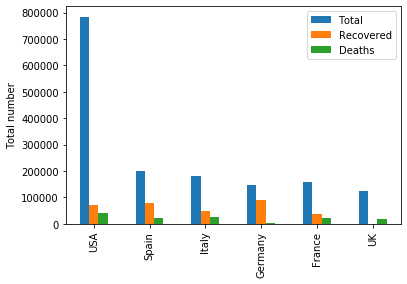

In [15]:
trd=[]

for cname in countries_list:
    trd.append(whichcountry(cname)[1:])
    
trd_df=pd.DataFrame(trd)
trd_df.columns=['Total','Recovered','Deaths']
trd_df.index=df_active.columns

trd_df.plot(kind='bar')
plt.ylabel('Total number')
plt.show()

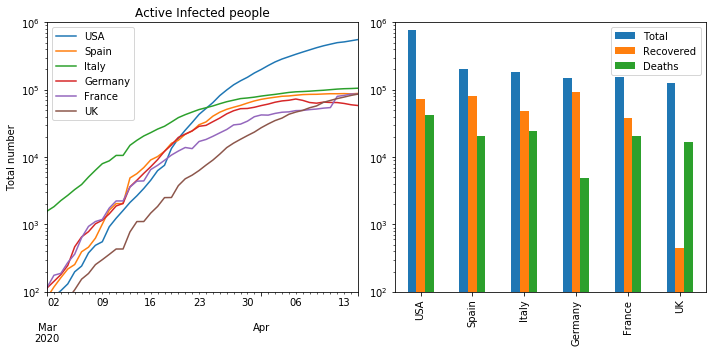

In [16]:
fig, axes = plt.subplots(figsize=(10,5),nrows=1, ncols=2)
ax1=plt.subplot(1,2,1)
df_active.plot(ax=ax1)
plt.xlim('2020-03-01','2020-04-15')
plt.title('Active Infected people')
plt.ylabel('Total number')
plt.yscale('log')
plt.ylim(10**2,10**6)
ax2=plt.subplot(1,2,2)
trd_df.plot(kind='bar',ax=ax2)
plt.yscale('log')
plt.ylim(10**2,10**6)
plt.tight_layout()
plt.savefig('output/world_comparison.png',dpi=300)

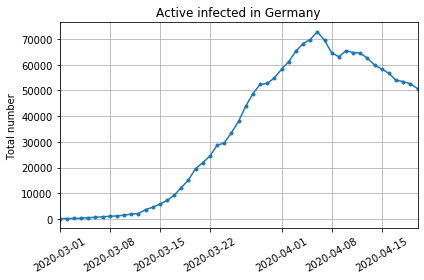

In [25]:
plt.plot(df_time,whichcountry('Germany')[0],marker='.')
plt.xticks(rotation=30)
plt.xlim('2020-03-01','2020-04-20')
plt.title('Active infected in Germany')
plt.ylabel('Total number')
plt.grid()
plt.tight_layout()
plt.savefig('output/germany_active_infected.png',dpi=300)
plt.show()

In [18]:
df_DEU=pd.DataFrame(df_time) 
df_DEU['y_inf']=whichcountry('Germany')[0]
df_DEU.columns=['time','y_inf']

df_DEU.to_csv('y_inf_DEU.txt',index=False)

### Old code

In [19]:
'''
from scipy.optimize import curve_fit

def func(t,t0,a):
    #return (a-b*t)**(t-t0)
    return a**(t-t0)

x_ITA=pd.to_datetime(df_confirmed.columns[4:],format='%m/%d/%y')

tdelta=x_ITA-t0  #this should be adapted to the country

xdata2=tdelta.days
xdata=xdata2[xdata2>=0]

ydata=np.array(func_plot(df_confirmed_ITA)[1])
ydata=ydata[xdata2>=0]

ydata_death=np.array(func_plot(df_deaths_ITA)[1])
ydata_death=ydata_death[xdata2>=0]

mask=xdata2>=0

ydata_rec=np.array(func_plot(df_recovered_ITA)[1])
ydata_rec=ydata_rec[mask[0:len(mask)-1]]

popt, pcov = curve_fit(func, xdata, ydata,p0=[0,2])

def func_death(t,mort_rate):
    return mort_rate*popt[1]**(t-popt[0])

popt_death, pcov_death = curve_fit(func_death, xdata, ydata_death)

plt.figure(figsize=(5,5))
plt.plot(xdata, func(xdata, *popt), 'b--')
plt.plot(xdata, func_death(xdata, *popt_death), color='orange',linestyle='--')
plt.errorbar(xdata,ydata,np.sqrt(ydata),linestyle='None',label='Contaminated',marker='s')
plt.errorbar(xdata,ydata_death,np.sqrt(ydata_death),linestyle='None',label='Deaths',marker='s')
plt.errorbar(xdata[0:len(xdata)-1],ydata_rec,np.sqrt(ydata_rec),linestyle='None',label='Recovered',marker='s')
plt.yscale('log')
plt.legend()
plt.xlabel('Days from the beginning')
plt.ylabel('Number')
plt.savefig('evoita.png',dpi=300)
plt.show()
'''

"\nfrom scipy.optimize import curve_fit\n\ndef func(t,t0,a):\n    #return (a-b*t)**(t-t0)\n    return a**(t-t0)\n\nx_ITA=pd.to_datetime(df_confirmed.columns[4:],format='%m/%d/%y')\n\ntdelta=x_ITA-t0  #this should be adapted to the country\n\nxdata2=tdelta.days\nxdata=xdata2[xdata2>=0]\n\nydata=np.array(func_plot(df_confirmed_ITA)[1])\nydata=ydata[xdata2>=0]\n\nydata_death=np.array(func_plot(df_deaths_ITA)[1])\nydata_death=ydata_death[xdata2>=0]\n\nmask=xdata2>=0\n\nydata_rec=np.array(func_plot(df_recovered_ITA)[1])\nydata_rec=ydata_rec[mask[0:len(mask)-1]]\n\npopt, pcov = curve_fit(func, xdata, ydata,p0=[0,2])\n\ndef func_death(t,mort_rate):\n    return mort_rate*popt[1]**(t-popt[0])\n\npopt_death, pcov_death = curve_fit(func_death, xdata, ydata_death)\n\nplt.figure(figsize=(5,5))\nplt.plot(xdata, func(xdata, *popt), 'b--')\nplt.plot(xdata, func_death(xdata, *popt_death), color='orange',linestyle='--')\nplt.errorbar(xdata,ydata,np.sqrt(ydata),linestyle='None',label='Contaminated',marke

In [20]:
'''

print('The number of contaminated people increases everyday of a factor',round(popt[1],2))

print('Prediction for the number of contaminated people in 1 week',int(func(xdata[-1]+7, *popt)))

print('Prediction for the number of func_deaths in 1 week',int(func_death(xdata[-1]+7, *popt_death)))

# percentage variation of the contaminted people, compared to the previous day

incremento=[]

for i in range(3,len(ydata)):
    incremento.append((ydata[i]/ydata[i-1]-1)*100)
    
plt.bar(xdata[xdata>=3],incremento)
plt.xlabel('Days from the beginning')
plt.ylabel('% variation from the previous day')
plt.savefig('incr_perc.png',dpi=300)
plt.show()

### combined plot

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(xdata, func(xdata, *popt), 'b--')
plt.plot(xdata, func_death(xdata, *popt_death), color='orange',linestyle='--')
plt.errorbar(xdata,ydata,np.sqrt(ydata),linestyle='None',label='Contaminated',marker='s')
plt.errorbar(xdata,ydata_death,np.sqrt(ydata_death),linestyle='None',label='Deaths',marker='s')
#plt.errorbar(xdata,ydata_rec,np.sqrt(ydata_rec),linestyle='None',label='Recovered',marker='s')
plt.yscale('log')
plt.legend()
plt.xlabel('Days from the beginning')
plt.ylabel('Number')
plt.subplot(1,2,2)
plt.bar(xdata[xdata>=3],incremento)
plt.xlabel('Days from the beginning')
plt.ylabel('% variation compared to the previous day')
plt.tight_layout()
plt.savefig('combined.png',dpi=300)
plt.show()

# save data from Italy on an external file

vec_ITA=xdata,ydata,ydata_death,np.concatenate([[0],ydata_rec])
vec_ITA=np.transpose(vec_ITA)

df_ITA=pd.DataFrame(vec_ITA)
df_ITA.columns=(['Time','Infected','Deaths','Recovered'])

if country=='Italy':
    df_ITA.to_csv('dataITA.txt',index=None)
elif country=='Germany':
    df_ITA.to_csv('dataDEU.txt',index=None)
    
'''

"\n\nprint('The number of contaminated people increases everyday of a factor',round(popt[1],2))\n\nprint('Prediction for the number of contaminated people in 1 week',int(func(xdata[-1]+7, *popt)))\n\nprint('Prediction for the number of func_deaths in 1 week',int(func_death(xdata[-1]+7, *popt_death)))\n\n# percentage variation of the contaminted people, compared to the previous day\n\nincremento=[]\n\nfor i in range(3,len(ydata)):\n    incremento.append((ydata[i]/ydata[i-1]-1)*100)\n    \nplt.bar(xdata[xdata>=3],incremento)\nplt.xlabel('Days from the beginning')\nplt.ylabel('% variation from the previous day')\nplt.savefig('incr_perc.png',dpi=300)\nplt.show()\n\n### combined plot\n\nplt.figure(figsize=(10,5))\nplt.subplot(1,2,1)\nplt.plot(xdata, func(xdata, *popt), 'b--')\nplt.plot(xdata, func_death(xdata, *popt_death), color='orange',linestyle='--')\nplt.errorbar(xdata,ydata,np.sqrt(ydata),linestyle='None',label='Contaminated',marker='s')\nplt.errorbar(xdata,ydata_death,np.sqrt(ydata_d